In [13]:
# Copyright (c) 2024 Byeonghyeon Kim 
# github site: https://github.com/bhkim003/ByeonghyeonKim
# email: bhkim003@snu.ac.kr
 
# Permission is hereby granted, free of charge, to any person obtaining a copy of
# this software and associated documentation files (the "Software"), to deal in
# the Software without restriction, including without limitation the rights to
# use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of
# the Software, and to permit persons to whom the Software is furnished to do so,
# subject to the following conditions:
 
# The above copyright notice and this permission notice shall be included in all
# copies or substantial portions of the Software.
 
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS
# FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR
# COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER
# IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN
# CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.


In [14]:
import sys
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torch.utils.data import Dataset, DataLoader

import torchvision
import torchvision.datasets
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt

import time

from snntorch import spikegen
import matplotlib.pyplot as plt
import snntorch.spikeplot as splt
from IPython.display import HTML

from tqdm import tqdm

from apex.parallel import DistributedDataParallel as DDP

import random
import datetime

import json

In [15]:
# my module import
from modules import *

# modules 폴더에 새모듈.py 만들면
# modules/__init__py 파일에 form .새모듈 import * 하셈
# 그리고 새모듈.py에서 from modules.새모듈 import * 하셈


In [16]:
def my_snn_system(devices = "0,1,2,3",
                    my_seed = 42,
                    TIME = 8,
                    BATCH = 256,
                    IMAGE_SIZE = 32,
                    which_data = 'CIFAR10',
                    CLASS_NUM = 10,
                    data_path = '/data2',
                    rate_coding = True,
    
                    lif_layer_v_init = 0.0,
                    lif_layer_v_decay = 0.6,
                    lif_layer_v_threshold = 1.2,
                    lif_layer_v_reset = 0.0,
                    lif_layer_sg_width = 1,

                    # synapse_conv_in_channels = IMAGE_PIXEL_CHANNEL,
                    synapse_conv_kernel_size = 3,
                    synapse_conv_stride = 1,
                    synapse_conv_padding = 1,
                    synapse_conv_trace_const1 = 1,
                    synapse_conv_trace_const2 = 0.6,

                    # synapse_fc_out_features = CLASS_NUM,
                    synapse_fc_trace_const1 = 1,
                    synapse_fc_trace_const2 = 0.6,

                    pre_trained = False,
                    convTrue_fcFalse = True,
                    cfg = [64, 64],
                    net_print = False, # True # False
                    pre_trained_path = "net_save/save_now_net.pth",
                    learning_rate = 0.0001,
                    epoch_num = 200,
                    verbose_interval = 100, #숫자 크게 하면 꺼짐
                    validation_interval = 10, #숫자 크게 하면 꺼짐
                    tdBN_on = False,
                    BN_on = False,

                    surrogate = 'sigmoid',

                    gradient_verbose = False,

                    BPTT_on = False,

                    scheduler_name = 'no',
                    
                    ddp_on = True,

                    nda_net = False,
                  ):
    # 함수 내 모든 로컬 변수 저장
    hyperparameters = locals()
    hyperparameters['top_train_acc_one_iter'] = 0
    hyperparameters['top_val_acc'] = 0

    os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID" 
    os.environ["CUDA_VISIBLE_DEVICES"]= devices

    
    torch.manual_seed(my_seed)


    
    # data loader, pixel channel, class num
    train_loader, test_loader, synapse_conv_in_channels = data_loader(
            which_data,
            data_path, 
            rate_coding, 
            BATCH, 
            IMAGE_SIZE,
            ddp_on)
    synapse_fc_out_features = CLASS_NUM


    ## parameter number calculator ##########################################
    params_num = 0
    img_size = IMAGE_SIZE 
    bias_param = 1 # 1 or 0
    classifier_making = False
    if (convTrue_fcFalse == True):
        past_kernel = synapse_conv_in_channels
        for kernel in cfg:
            if (classifier_making == False):
                if (type(kernel) == list):
                    for residual_kernel in kernel:
                        params_num += residual_kernel * ((synapse_conv_kernel_size**2) * past_kernel + bias_param)
                        past_kernel = residual_kernel
                elif (kernel == 'P' or kernel == 'M'):
                    img_size = img_size // 2
                elif (kernel == 'L'):
                    classifier_making = True
                    past_kernel = past_kernel * (img_size**2)
                else:
                    params_num += kernel * (synapse_conv_kernel_size**2 * past_kernel + bias_param)
                    past_kernel = kernel    
            else: # classifier making
                params_num += (past_kernel + bias_param) * kernel
                past_kernel = kernel
        
        
        if classifier_making == False:
            past_kernel = past_kernel*img_size*img_size

        params_num += (past_kernel + bias_param) * synapse_fc_out_features
    else:
        past_in_channel = synapse_conv_in_channels*img_size*img_size
        for in_channel in cfg:
            if (type(in_channel) == list):
                for residual_in_channel in in_channel:
                    params_num += (past_in_channel + bias_param) * residual_in_channel
                    past_in_channel = residual_in_channel
            # elif (in_channel == 'M'): #it's a holy FC layer!
            #     img_size = img_size // 2
            else:
                params_num += (past_in_channel + bias_param) * in_channel
                past_in_channel = in_channel
        params_num += (past_in_channel + bias_param) * synapse_fc_out_features
    ## parameter number calculator ##########################################


    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    if pre_trained == False:
        if (convTrue_fcFalse == False):
            net = MY_SNN_FC(cfg, synapse_conv_in_channels, IMAGE_SIZE, synapse_fc_out_features,
                     synapse_fc_trace_const1, synapse_fc_trace_const2, 
                     lif_layer_v_init, lif_layer_v_decay, 
                     lif_layer_v_threshold, lif_layer_v_reset,
                     lif_layer_sg_width,
                     tdBN_on,
                     BN_on, TIME,
                     surrogate,
                     BPTT_on).to(device)
        else:
            net = MY_SNN_CONV(cfg, synapse_conv_in_channels, IMAGE_SIZE,
                     synapse_conv_kernel_size, synapse_conv_stride, 
                     synapse_conv_padding, synapse_conv_trace_const1, 
                     synapse_conv_trace_const2, 
                     lif_layer_v_init, lif_layer_v_decay, 
                     lif_layer_v_threshold, lif_layer_v_reset,
                     lif_layer_sg_width,
                     synapse_fc_out_features, synapse_fc_trace_const1, synapse_fc_trace_const2,
                     tdBN_on,
                     BN_on, TIME,
                     surrogate,
                     BPTT_on).to(device)
        
        if (nda_net == True):
            net = VGG(cfg = cfg, num_classes=10, batch_norm = tdBN_on, in_c = synapse_conv_in_channels, 
                      lif_layer_v_threshold=lif_layer_v_threshold, lif_layer_v_decay=lif_layer_v_decay, lif_layer_sg_width=lif_layer_sg_width)
            net.T = TIME
        net = torch.nn.DataParallel(net)
    else:
        net = torch.load(pre_trained_path)


    net = net.to(device)
    if (net_print == True):
        print(net)
    
    ## param num and memory estimation except BN at MY calculation ##########################################
    real_param_num = sum(p.numel() for p in net.parameters() if p.requires_grad)
    # Batch norm 있으면 아래 두 개 서로 다를 수 있음.
    # assert real_param_num == params_num, f'parameter number is not same. real_param_num: {real_param_num}, params_num: {params_num}'    
    print('='*50)
    print(f"My Num of PARAMS: {params_num:,}, system's param_num : {real_param_num:,}")
    memory = params_num / 8 / 1024 / 1024 # MB
    precision = 32
    memory = memory * precision 
    print(f"Memory: {memory:.2f}MiB at {precision}-bit")
    print('='*50)
    ##########################################################################

    criterion = nn.CrossEntropyLoss().to(device)
    # optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)
    optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9, weight_decay=0)
    # optimizer = torch.optim.Adam(net.parameters(), lr=0.00001)
    # optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate/256 * BATCH, weight_decay=1e-4)
    # optimizer = optim.Adam(net.parameters(), lr=learning_rate, weight_decay=0, betas=(0.9, 0.999))


    if (scheduler_name == 'StepLR'):
        scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
    elif (scheduler_name == 'ExponentialLR'):
        scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.95)
    elif (scheduler_name == 'ReduceLROnPlateau'):
        scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10)
    elif (scheduler_name == 'CosineAnnealingLR'):
        scheduler = lr_scheduler.CosineAnnealingLR(optimizer, eta_min=0, T_max=50)
    elif (scheduler_name == 'OneCycleLR'):
        scheduler = lr_scheduler.OneCycleLR(optimizer, max_lr=0.1, steps_per_epoch=len(train_loader), epochs=100)
    else:
        pass # 'no' scheduler

    val_acc = 0
    val_acc_now = 0
    elapsed_time_val = 0
    train_acc_array = np.array([])
    val_acc_now_array = np.array([])
    current_time = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    for epoch in range(epoch_num):
        print('EPOCH', epoch)
        epoch_start_time = time.time()
        running_loss = 0.0
        
        iterator = enumerate(train_loader, 0)
        if (ddp_on == True):
            if torch.distributed.get_rank() == 0:   
                iterator = tqdm(iterator, total=len(train_loader), desc='train', dynamic_ncols=True, position=0, leave=True)
        else:
            iterator = tqdm(iterator, total=len(train_loader), desc='train', dynamic_ncols=True, position=0, leave=True)

        for i, data in iterator:
            iter_one_train_time_start = time.time()
            net.train()

            ## data loading #################################
            inputs, labels = data

            
            if (which_data == 'DVS-CIFAR10'):
                inputs = inputs.permute(1, 0, 2, 3, 4)
            elif rate_coding == True :
                inputs = spikegen.rate(inputs, num_steps=TIME)
            else :
                inputs = inputs.repeat(TIME, 1, 1, 1, 1)
            # inputs: [Time, Batch, Channel, Height, Width]  
            ################################################# 

            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            # inputs: [Time, Batch, Channel, Height, Width]   
            inputs = inputs.permute(1, 0, 2, 3, 4) # net에 넣어줄때는 batch가 젤 앞 차원으로 와야함. # dataparallel때매
            # inputs: [Batch, Time, Channel, Height, Width]   
        
            outputs = net(inputs)

            batch = BATCH 
            if labels.size(0) != BATCH: 
                batch = labels.size(0)

            


            ####### training accruacy print ###############################
            correct = 0
            total = 0
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted[0:batch] == labels).sum().item()
            train_acc = correct / total
            if i % verbose_interval == verbose_interval-1:
                print(f'{epoch}-{i} training acc: {100 * train_acc:.2f}%, lr={[f"{lr}" for lr in (param_group["lr"] for param_group in optimizer.param_groups)]}, val_acc: {100 * val_acc_now:.2f}%')
            training_acc_string = f'{epoch}-{i}/{len(train_loader)} tr_acc: {100 * correct / total:.2f}%, lr={[f"{lr}" for lr in (param_group["lr"] for param_group in optimizer.param_groups)]}'
            
            ################################################################
            

            loss = criterion(outputs[0:batch,:], labels)
            loss.backward()


            ### gradinet verbose ##########################################
            if (gradient_verbose == True):
                if (i % verbose_interval == verbose_interval-1):
                    print('\n\nepoch', epoch, 'iter', i)
                    for name, param in net.named_parameters():
                        if param.requires_grad:
                            print('\n\n\n\n' , name, param.grad)
            ################################################################
            
            optimizer.step()

            running_loss += loss.item()
            # print("Epoch: {}, Iter: {}, Loss: {}".format(epoch + 1, i + 1, running_loss / 100))

            iter_one_train_time_end = time.time()
            elapsed_time = iter_one_train_time_end - iter_one_train_time_start  # 실행 시간 계산

            if (i % verbose_interval == verbose_interval-1):
                print(f"iter_one_train_time: {elapsed_time} seconds, last one_val_time: {elapsed_time_val} seconds\n")

            ##### validation ##############################################
            if i % validation_interval == validation_interval-1:
                iter_one_val_time_start = time.time()
                
                correct = 0
                total = 0
                with torch.no_grad():
                    net.eval()
                    for data in test_loader:
                        ## data loading #################################
                        inputs, labels = data

                        
                        if (which_data == 'DVS-CIFAR10'):
                            inputs = inputs.permute(1, 0, 2, 3, 4)
                        elif rate_coding == True :
                            inputs = spikegen.rate(inputs, num_steps=TIME)
                        else :
                            inputs = inputs.repeat(TIME, 1, 1, 1, 1)
                        # inputs: [Time, Batch, Channel, Height, Width]  
                        ################################################# 

                        inputs = inputs.to(device)
                        labels = labels.to(device)
                        outputs = net(inputs.permute(1, 0, 2, 3, 4))
                        _, predicted = torch.max(outputs.data, 1)
                        total += labels.size(0)
                        batch = BATCH 
                        if labels.size(0) != BATCH: 
                            batch = labels.size(0)
                        correct += (predicted[0:batch] == labels).sum().item()
                        val_loss = criterion(outputs[0:batch,:], labels)

                    val_acc_now = correct / total
                    # print(f'{epoch}-{i} validation acc: {100 * val_acc_now:.2f}%, lr={[f"{lr:.10f}" for lr in (param_group["lr"] for param_group in optimizer.param_groups)]}')

                iter_one_val_time_end = time.time()
                elapsed_time_val = iter_one_val_time_end - iter_one_val_time_start  # 실행 시간 계산
                # print(f"iter_one_val_time: {elapsed_time_val} seconds")

                # network save
                if val_acc < val_acc_now:
                    val_acc = val_acc_now
                    torch.save(net.state_dict(), "net_save/save_now_net_weights.pth")
                    torch.save(net, "net_save/save_now_net.pth")
                    torch.save(net.module.state_dict(), "net_save/save_now_net_weights2.pth")
                    torch.save(net.module, "net_save/save_now_net2.pth")
            ################################################################
            iterator.set_description(f"train: {training_acc_string}, tr_loss: {loss}, val_acc: {100 * val_acc_now:.2f}%")  

            train_acc_array = np.append(train_acc_array, train_acc)
            val_acc_now_array = np.append(val_acc_now_array, val_acc_now)
            base_name = f'{current_time}'
            train_acc_file_name = f'result_save/{base_name}_train_acc_array.npy'
            val_acc_file_name = f'result_save/{base_name}_val_acc_now_array.npy'
            hyperparameters_file_name = f'result_save/{base_name}_hyperparameters.json'

            if(train_acc > hyperparameters['top_train_acc_one_iter']):
                hyperparameters['top_train_acc_one_iter'] = train_acc
            if(val_acc_now > hyperparameters['top_val_acc']):
                hyperparameters['top_val_acc'] = val_acc_now

            np.save(train_acc_file_name, train_acc_array)
            np.save(val_acc_file_name, val_acc_now_array)
            with open(hyperparameters_file_name, 'w') as f:
                json.dump(hyperparameters, f, indent=4)

            np.save('result_save/train_acc_array.npy', train_acc_array)
            np.save('result_save/val_acc_now_array.npy', val_acc_now_array)
            with open('result_save/hyperparameters.json', 'w') as f:
                json.dump(hyperparameters, f, indent=4)
            
        if (scheduler_name != 'no'):
            if (scheduler_name == 'ReduceLROnPlateau'):
                scheduler.step(val_loss)
            else:
                scheduler.step()

        
        
        epoch_time_end = time.time()
        epoch_time = epoch_time_end - epoch_start_time  # 실행 시간 계산
        
        print(f"epoch_time: {epoch_time} seconds")
        print('\n')


In [17]:
### my_snn control board ########################
decay = 0.5 # 0.875 0.25 0.125 0.75 0.5
# nda 0.25 # ottt 0.5

my_snn_system(  devices = "0,1,2,3,4,5",
                my_seed = 42,
                TIME = 10, # dvscifar 10 # ottt 6 or 10
                BATCH = 128, # batch norm 할거면 2이상으로 해야함   # nda 256   #  ottt 128
                IMAGE_SIZE = 48, # dvscifar 48 # MNIST 28 # CIFAR10 32

                # DVS-CIFAR10 할거면 time 10으로 해라
                which_data = 'DVS-CIFAR10',# 'CIFAR10' 'MNIST' 'FASHION_MNIST' 'DVS-CIFAR10'
                CLASS_NUM = 10,
                data_path = '/data2', # YOU NEED TO CHANGE THIS
                rate_coding = False, # True # False

                lif_layer_v_init = 0.0,
                lif_layer_v_decay = decay,
                lif_layer_v_threshold = 1.0, # nda 0.5  # ottt 1.0
                lif_layer_v_reset = 0.0, #현재 안씀. 걍 빼기 해버림
                lif_layer_sg_width = 1.0, # surrogate sigmoid 쓸 때는 의미없음

                # synapse_conv_in_channels = IMAGE_PIXEL_CHANNEL,
                synapse_conv_kernel_size = 3,
                synapse_conv_stride = 1,
                synapse_conv_padding = 1,
                synapse_conv_trace_const1 = 1,
                synapse_conv_trace_const2 = decay, # lif_layer_v_decay

                # synapse_fc_out_features = CLASS_NUM,
                synapse_fc_trace_const1 = 1,
                synapse_fc_trace_const2 = decay, # lif_layer_v_decay

                pre_trained = False, # True # False
                convTrue_fcFalse = True, # True # False

                # 'P' for average pooling, 'M' for maxpooling, 'L' for linear classifier, [  ] for residual block
                # cfg = [64],
                # cfg = [64,[64,64],64], # 끝에 linear classifier 하나 자동으로 붙습니다
                # cfg = [64, 128, 'P', 256, 256, 'P', 512, 512, 'P', 512, 512], 
                cfg = [64, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512], # ottt 
                # cfg = [64, 'P', 128, 'P', 256, 256, 'P', 512, 512, 512, 512], # nda
                # cfg = [64, 'P', 128, 'P', 256, 256, 'P', 512, 512, 512, 512, 'L', 4096, 4096],


                net_print = False, # True # False
                pre_trained_path = "net_save/save_now_net.pth",
                learning_rate = 0.001,  # ottt 0.1  # nda 0.001
                epoch_num = 200,
                verbose_interval = 50, #숫자 크게 하면 꺼짐
                validation_interval = 50, #숫자 크게 하면 꺼짐
                tdBN_on = False,  # True # False
                BN_on = True,  # True # False
                
                surrogate = 'sigmoid', # 'rectangle' 'sigmoid' 'rough_rectangle'
                
                gradient_verbose = False,  # True # False  # weight gradient 각 layer마다 띄워줌

                BPTT_on = False,  # True # False # True이면 BPTT, False이면 OTTT

                scheduler_name = 'CosineAnnealingLR', # 'no' 'StepLR' 'ExponentialLR' 'ReduceLROnPlateau' 'CosineAnnealingLR' 'OneCycleLR'
                
                ddp_on = False,   # True # False

                nda_net = False,   # True # False
                ) 
# sigmoid와 BN이 있어야 잘된다.
# average pooling이 낫다.

# nda에서는 decay = 0.25, threshold = 0.5, width =1, surrogate = rectangle, batch = 256, tdBN = True
## OTTT 에서는 decay = 0.5, threshold = 1.0, surrogate = sigmoid, batch = 128, BN = True


My Num of PARAMS: 9,265,418, system's param_num : 9,320,458
Memory: 35.34MiB at 32-bit
current_time 20240628_110116
EPOCH 0


train: 0-48/469 tr_acc: 66.41%, lr=['0.001'], tr_loss: 0.8661904335021973, val_acc: 0.00%:  10%|█         | 49/469 [00:45<04:46,  1.47it/s]

0-49 training acc: 64.84%, lr=['0.001'], val_acc: 0.00%
iter_one_train_time: 0.6943104267120361 seconds, last one_val_time: 0 seconds



train: 0-98/469 tr_acc: 76.56%, lr=['0.001'], tr_loss: 0.6487302184104919, val_acc: 46.00%:  21%|██        | 99/469 [01:42<04:16,  1.44it/s] 

0-99 training acc: 82.03%, lr=['0.001'], val_acc: 46.00%
iter_one_train_time: 0.6385259628295898 seconds, last one_val_time: 20.83829355239868 seconds



train: 0-148/469 tr_acc: 82.03%, lr=['0.001'], tr_loss: 0.527456521987915, val_acc: 76.45%:  32%|███▏      | 149/469 [02:42<03:54,  1.37it/s]  

0-149 training acc: 74.22%, lr=['0.001'], val_acc: 76.45%
iter_one_train_time: 0.6879923343658447 seconds, last one_val_time: 20.271543741226196 seconds



train: 0-198/469 tr_acc: 82.03%, lr=['0.001'], tr_loss: 0.48052701354026794, val_acc: 81.07%:  42%|████▏     | 199/469 [03:40<03:21,  1.34it/s]

0-199 training acc: 90.62%, lr=['0.001'], val_acc: 81.07%
iter_one_train_time: 0.7278192043304443 seconds, last one_val_time: 20.662537813186646 seconds



train: 0-248/469 tr_acc: 77.34%, lr=['0.001'], tr_loss: 0.5379104018211365, val_acc: 82.68%:  53%|█████▎    | 249/469 [04:38<02:34,  1.43it/s] 

0-249 training acc: 86.72%, lr=['0.001'], val_acc: 82.68%
iter_one_train_time: 0.7084033489227295 seconds, last one_val_time: 21.188638925552368 seconds



train: 0-298/469 tr_acc: 83.59%, lr=['0.001'], tr_loss: 0.4301880896091461, val_acc: 82.69%:  64%|██████▍   | 299/469 [05:36<02:00,  1.41it/s] 

0-299 training acc: 86.72%, lr=['0.001'], val_acc: 82.69%
iter_one_train_time: 0.6519279479980469 seconds, last one_val_time: 21.63379716873169 seconds



train: 0-348/469 tr_acc: 89.84%, lr=['0.001'], tr_loss: 0.35226231813430786, val_acc: 82.72%:  74%|███████▍  | 349/469 [06:35<01:31,  1.32it/s]

0-349 training acc: 89.06%, lr=['0.001'], val_acc: 82.72%
iter_one_train_time: 0.6840541362762451 seconds, last one_val_time: 21.05369782447815 seconds



train: 0-398/469 tr_acc: 87.50%, lr=['0.001'], tr_loss: 0.37253496050834656, val_acc: 84.61%:  85%|████████▌ | 399/469 [07:33<00:51,  1.35it/s]

0-399 training acc: 85.94%, lr=['0.001'], val_acc: 84.61%
iter_one_train_time: 0.7249126434326172 seconds, last one_val_time: 21.184992790222168 seconds



train: 0-448/469 tr_acc: 88.28%, lr=['0.001'], tr_loss: 0.3473159074783325, val_acc: 82.88%:  96%|█████████▌| 449/469 [08:30<00:13,  1.43it/s] 

0-449 training acc: 89.06%, lr=['0.001'], val_acc: 82.88%
iter_one_train_time: 0.6518316268920898 seconds, last one_val_time: 20.84855318069458 seconds



train: 0-468/469 tr_acc: 85.42%, lr=['0.001'], tr_loss: 0.4552634656429291, val_acc: 82.77%: 100%|██████████| 469/469 [09:06<00:00,  1.16s/it] 

epoch_time: 546.2855207920074 seconds


EPOCH 1



train: 1-48/469 tr_acc: 89.06%, lr=['0.0009990133642141358'], tr_loss: 0.3445945382118225, val_acc: 82.77%:  10%|█         | 49/469 [00:35<05:00,  1.40it/s] 

1-49 training acc: 85.16%, lr=['0.0009990133642141358'], val_acc: 82.77%
iter_one_train_time: 0.7388277053833008 seconds, last one_val_time: 21.242027759552002 seconds



train: 1-98/469 tr_acc: 89.84%, lr=['0.0009990133642141358'], tr_loss: 0.2989249527454376, val_acc: 84.30%:  21%|██        | 99/469 [01:33<04:36,  1.34it/s] 

1-99 training acc: 89.84%, lr=['0.0009990133642141358'], val_acc: 84.30%
iter_one_train_time: 0.7326278686523438 seconds, last one_val_time: 20.9297354221344 seconds



train: 1-148/469 tr_acc: 85.16%, lr=['0.0009990133642141358'], tr_loss: 0.38502055406570435, val_acc: 85.21%:  32%|███▏      | 149/469 [02:31<03:45,  1.42it/s]

1-149 training acc: 78.91%, lr=['0.0009990133642141358'], val_acc: 85.21%
iter_one_train_time: 0.7055227756500244 seconds, last one_val_time: 21.001160383224487 seconds



train: 1-198/469 tr_acc: 88.28%, lr=['0.0009990133642141358'], tr_loss: 0.2621143162250519, val_acc: 86.81%:  42%|████▏     | 199/469 [03:29<03:12,  1.40it/s] 

1-199 training acc: 86.72%, lr=['0.0009990133642141358'], val_acc: 86.81%
iter_one_train_time: 0.707280158996582 seconds, last one_val_time: 21.363625049591064 seconds



train: 1-248/469 tr_acc: 89.06%, lr=['0.0009990133642141358'], tr_loss: 0.3474980890750885, val_acc: 87.45%:  53%|█████▎    | 249/469 [04:28<02:45,  1.33it/s] 

1-249 training acc: 93.75%, lr=['0.0009990133642141358'], val_acc: 87.45%
iter_one_train_time: 0.7076783180236816 seconds, last one_val_time: 20.89100193977356 seconds



train: 1-298/469 tr_acc: 92.97%, lr=['0.0009990133642141358'], tr_loss: 0.246195986866951, val_acc: 85.07%:  64%|██████▍   | 299/469 [05:25<02:02,  1.38it/s]  

1-299 training acc: 90.62%, lr=['0.0009990133642141358'], val_acc: 85.07%
iter_one_train_time: 0.7060556411743164 seconds, last one_val_time: 21.076703786849976 seconds



train: 1-348/469 tr_acc: 89.84%, lr=['0.0009990133642141358'], tr_loss: 0.31017550826072693, val_acc: 87.94%:  74%|███████▍  | 349/469 [06:24<01:26,  1.39it/s]

1-349 training acc: 88.28%, lr=['0.0009990133642141358'], val_acc: 87.94%
iter_one_train_time: 0.8329784870147705 seconds, last one_val_time: 21.5656795501709 seconds



train: 1-398/469 tr_acc: 92.19%, lr=['0.0009990133642141358'], tr_loss: 0.20449167490005493, val_acc: 87.42%:  85%|████████▌ | 399/469 [07:22<00:51,  1.37it/s]

1-399 training acc: 87.50%, lr=['0.0009990133642141358'], val_acc: 87.42%
iter_one_train_time: 0.7123253345489502 seconds, last one_val_time: 20.74421763420105 seconds



train: 1-448/469 tr_acc: 85.94%, lr=['0.0009990133642141358'], tr_loss: 0.3092406094074249, val_acc: 87.51%:  96%|█████████▌| 449/469 [08:20<00:14,  1.36it/s] 

1-449 training acc: 85.16%, lr=['0.0009990133642141358'], val_acc: 87.51%
iter_one_train_time: 0.7330350875854492 seconds, last one_val_time: 21.18929409980774 seconds



train: 1-468/469 tr_acc: 93.75%, lr=['0.0009990133642141358'], tr_loss: 0.18148821592330933, val_acc: 86.11%: 100%|██████████| 469/469 [08:56<00:00,  1.14s/it]

epoch_time: 536.8651320934296 seconds


EPOCH 2



train: 2-48/469 tr_acc: 85.94%, lr=['0.000996057350657239'], tr_loss: 0.3883194625377655, val_acc: 86.11%:  10%|█         | 49/469 [00:36<05:27,  1.28it/s] 

2-49 training acc: 85.94%, lr=['0.000996057350657239'], val_acc: 86.11%
iter_one_train_time: 0.705941915512085 seconds, last one_val_time: 21.647257804870605 seconds



train: 2-98/469 tr_acc: 90.62%, lr=['0.000996057350657239'], tr_loss: 0.21028468012809753, val_acc: 77.83%:  21%|██        | 99/469 [01:34<04:37,  1.33it/s]

2-99 training acc: 92.19%, lr=['0.000996057350657239'], val_acc: 77.83%
iter_one_train_time: 0.7178795337677002 seconds, last one_val_time: 20.913889169692993 seconds



train: 2-148/469 tr_acc: 92.19%, lr=['0.000996057350657239'], tr_loss: 0.26706966757774353, val_acc: 84.54%:  32%|███▏      | 149/469 [02:32<03:55,  1.36it/s]

2-149 training acc: 88.28%, lr=['0.000996057350657239'], val_acc: 84.54%
iter_one_train_time: 0.6797544956207275 seconds, last one_val_time: 21.24152159690857 seconds



train: 2-198/469 tr_acc: 90.62%, lr=['0.000996057350657239'], tr_loss: 0.2994171679019928, val_acc: 85.97%:  42%|████▏     | 199/469 [03:29<03:15,  1.38it/s] 

2-199 training acc: 88.28%, lr=['0.000996057350657239'], val_acc: 85.97%
iter_one_train_time: 0.7087802886962891 seconds, last one_val_time: 20.96687602996826 seconds



train: 2-248/469 tr_acc: 83.59%, lr=['0.000996057350657239'], tr_loss: 0.37483859062194824, val_acc: 87.57%:  53%|█████▎    | 249/469 [04:27<02:38,  1.38it/s]

2-249 training acc: 90.62%, lr=['0.000996057350657239'], val_acc: 87.57%
iter_one_train_time: 0.7529826164245605 seconds, last one_val_time: 21.383140802383423 seconds



train: 2-298/469 tr_acc: 92.19%, lr=['0.000996057350657239'], tr_loss: 0.2431497573852539, val_acc: 87.89%:  64%|██████▍   | 299/469 [05:25<02:02,  1.39it/s] 

2-299 training acc: 89.84%, lr=['0.000996057350657239'], val_acc: 87.89%
iter_one_train_time: 0.6935508251190186 seconds, last one_val_time: 21.061375379562378 seconds



train: 2-348/469 tr_acc: 90.62%, lr=['0.000996057350657239'], tr_loss: 0.1854880005121231, val_acc: 88.14%:  74%|███████▍  | 349/469 [06:24<01:26,  1.38it/s] 

2-349 training acc: 92.97%, lr=['0.000996057350657239'], val_acc: 88.14%
iter_one_train_time: 0.8781895637512207 seconds, last one_val_time: 21.15089225769043 seconds



train: 2-398/469 tr_acc: 85.16%, lr=['0.000996057350657239'], tr_loss: 0.3592950999736786, val_acc: 89.29%:  85%|████████▌ | 399/469 [07:22<00:53,  1.31it/s] 

2-399 training acc: 90.62%, lr=['0.000996057350657239'], val_acc: 89.29%
iter_one_train_time: 0.7542684078216553 seconds, last one_val_time: 20.862788677215576 seconds



train: 2-448/469 tr_acc: 92.19%, lr=['0.000996057350657239'], tr_loss: 0.27594447135925293, val_acc: 89.32%:  96%|█████████▌| 449/469 [08:20<00:14,  1.39it/s]

2-449 training acc: 90.62%, lr=['0.000996057350657239'], val_acc: 89.32%
iter_one_train_time: 0.6737892627716064 seconds, last one_val_time: 20.768675565719604 seconds



train: 2-468/469 tr_acc: 88.54%, lr=['0.000996057350657239'], tr_loss: 0.4049188792705536, val_acc: 87.35%: 100%|██████████| 469/469 [08:56<00:00,  1.14s/it] 

epoch_time: 536.928234577179 seconds


EPOCH 3



train: 3-48/469 tr_acc: 92.19%, lr=['0.0009911436253643444'], tr_loss: 0.23522397875785828, val_acc: 87.35%:  10%|█         | 49/469 [00:36<05:07,  1.37it/s]

3-49 training acc: 92.19%, lr=['0.0009911436253643444'], val_acc: 87.35%
iter_one_train_time: 0.7541022300720215 seconds, last one_val_time: 21.045328617095947 seconds



train: 3-98/469 tr_acc: 86.72%, lr=['0.0009911436253643444'], tr_loss: 0.2866836190223694, val_acc: 89.22%:  21%|██        | 99/469 [01:34<04:31,  1.36it/s] 

3-99 training acc: 94.53%, lr=['0.0009911436253643444'], val_acc: 89.22%
iter_one_train_time: 0.7267019748687744 seconds, last one_val_time: 21.454848527908325 seconds



train: 3-148/469 tr_acc: 89.84%, lr=['0.0009911436253643444'], tr_loss: 0.2540000379085541, val_acc: 88.65%:  32%|███▏      | 149/469 [02:32<03:52,  1.38it/s] 

3-149 training acc: 85.94%, lr=['0.0009911436253643444'], val_acc: 88.65%
iter_one_train_time: 0.7298319339752197 seconds, last one_val_time: 20.95405673980713 seconds



train: 3-163/469 tr_acc: 91.41%, lr=['0.0009911436253643444'], tr_loss: 0.20257242023944855, val_acc: 88.48%:  35%|███▍      | 164/469 [03:05<05:44,  1.13s/it]


KeyboardInterrupt: 

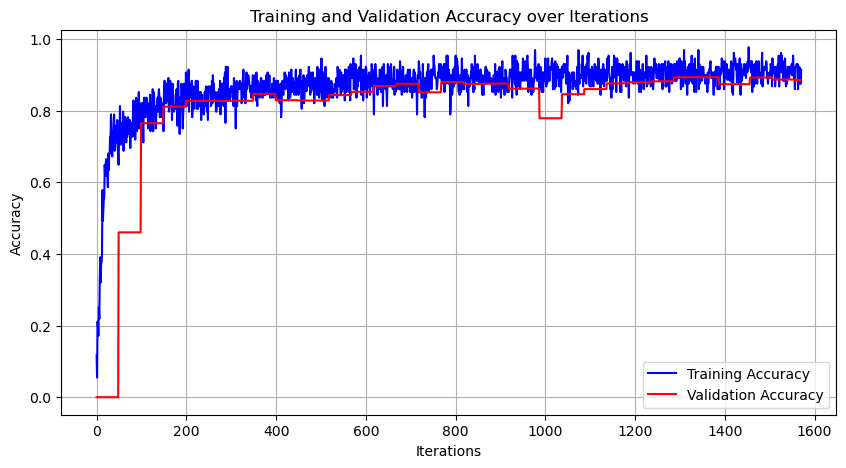

In [19]:
import numpy as np
import matplotlib.pyplot as plt

def pad_array_to_match_length(array1, array2):
    if len(array1) > len(array2):
        padded_array2 = np.pad(array2, (0, len(array1) - len(array2)), 'constant')
        return array1, padded_array2
    elif len(array2) > len(array1):
        padded_array1 = np.pad(array1, (0, len(array2) - len(array1)), 'constant')
        return padded_array1, array2
    else:
        return array1, array2
def load_hyperparameters(filename='hyperparameters.json'):
    with open(filename, 'r') as f:
        return json.load(f)
    




current_time = '20240628_110116'
base_name = f'{current_time}'
train_acc_file_name = f'result_save/{base_name}_train_acc_array.npy'
val_acc_file_name = f'result_save/{base_name}_val_acc_now_array.npy'
hyperparameters_file_name = f'result_save/{base_name}_hyperparameters.json'

### if you want to just see last train and val acc###########################
# train_acc_file_name = 'result_save/train_acc_array.npy'
# val_acc_file_name = 'result_save/val_acc_now_array.npy'
# hyperparameters_file_name = 'result_save/hyperparameters.json'

loaded_train_acc_array = np.load(train_acc_file_name)
loaded_val_acc_array = np.load(val_acc_file_name)
hyperparameters = load_hyperparameters(hyperparameters_file_name)

loaded_train_acc_array, loaded_val_acc_array = pad_array_to_match_length(loaded_train_acc_array, loaded_val_acc_array)



iterations = np.arange(len(loaded_train_acc_array))

# 그래프 그리기
plt.figure(figsize=(10, 5))
plt.plot(iterations, loaded_train_acc_array, label='Training Accuracy', color='b')
plt.plot(iterations, loaded_val_acc_array, label='Validation Accuracy', color='r')
plt.xlabel('Iterations')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy over Iterations')
plt.legend()
plt.grid(True)
plt.show()